In [1]:
import pystac_client
from odc import stac as odc_stac
import xarray as xr
import rioxarray
import numpy as np
import hvplot.xarray

Dask makes parallel computing easy by providing a familiar API common libraries, such as Pandas and Numpy. This allow efficient scaling of the here presented workflow for this adaptation of the TU Wien Bayesian flood mapping algorithm. The data size will be a main limiting factor as the data grows larger than RAM. For this reason we will partition our data in chunks which will presented to the machine workers by Dasks task scheduler in a most efficient manner. Although many of Dask' settings can be handled automatically, we can also modify some parameters for optimal performance of the workflow for the desired processing environment. So, note, that this highly depends on your own machine's specifications.

I will, furthermore, set the temporary directory for when Dask spills data from the workers memory to disk.


In [2]:
import dask
dask.config.set(temporary_directory='/tmp')

We can then set the Dask Client, where we avoid inter-worker communication which is common for working with `numpy` and `xarray` in this case.


In [3]:
from dask.distributed import Client, wait
client = Client(processes=False, threads_per_worker=2,
                n_workers=3, memory_limit='28GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.131.72.130:8787/status,
Dashboard: http://128.131.72.130:8787/status,Workers: 3
Total threads: 6,Total memory: 78.23 GiB
Status: running,Using processes: False
Comm: inproc://128.131.72.130/298906/1,Workers: 3
Dashboard: http://128.131.72.130:8787/status,Total threads: 6
Started: Just now,Total memory: 78.23 GiB
Comm: inproc://128.131.72.130/298906/4,Total threads: 2
Dashboard: http://128.131.72.130:34691/status,Memory: 26.08 GiB
Nanny: None,


In conjunction with setting up the Dask client I will chunk my arrays along three dimensions according to the following specifications for maximum performance on my setup. 


In [4]:
chunks = {'time':1, "latitude": 1300, "longitude": 1300}

## Cube Definitions

The following generic specifications are used for presenting the data.


In [5]:
crs = "EPSG:4326" # Coordinate Reference System - World Geodetic System 1984 (WGS84) in this case 
res = 0.00018 # 20 meter in degree

## Northern Germany Flood

Storm Babet hit the Denmark and Northern coast at the 20th of October 2023 [Wikipedia](https://en.wikipedia.org/wiki/Storm_Babet). Here an area around Zingst at the Baltic coast of Northern Germany is selected as the study area.


In [6]:
time_range = "2022-10-11/2022-10-25"
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]

## EODC STAC Catalog

The `pystac_client` establishes a connection to the EODC STAC Catalog. This results in a catalog object that can be used to discover collections and items hosted at EODC.


In [7]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

## Microwave Backscatter Measurements

The basic premise of microwave-based backscattering can be seen in the sketch below, the characteristics of backscattering over land and water differ considerably. With this knowledge we can detect whenever a pixel with a predominant land like signature changes to a water like signature in the event of flooding.

![](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)

*Schematic backscattering over land and water. Image from [Geological Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)*

We discover Sentinel-1 microwave backscatter ($\sigma_0$ [1]) at a 20 meter resolution, like so:


In [8]:
search = eodc_catalog.search(
    collections="SENTINEL1_SIG0_20M",
    bbox=bounding_box,
    datetime=time_range,
)

items_sig0 = search.item_collection()

The state of the orbit and relative orbit number is also saved, as the water and land likelihoods (which are calculated later on) dependent on the orbital configuration. These variables will be added as additional coordinates to the data cube. For this purpose a small helper function is defined, like so:


In [9]:
def extract_orbit_names(items):
    return np.array([items[i].properties["sat:orbit_state"][0].upper() + \
                     str(items[i].properties["sat:relative_orbit"]) \
                     for i in range(len(items))])

We will also save the scaling factor and nodata values of STAC items to correct the loaded data accordingly. Again a helper function will be used to correctly scale and fill no data values of the cube.


In [10]:
def post_process_eodc_cube(dc: xr.Dataset, items, bands):
    if not isinstance(bands, tuple):
        bands = tuple([bands])
    for i in bands:
        dc[i] = post_process_eodc_cube_(dc[i], items, i)
    return dc

def post_process_eodc_cube_(dc: xr.Dataset, items, band):
    scale = items[0].assets[band].extra_fields.get('raster:bands')[0]['scale']
    nodata = items[0].assets[band].extra_fields.get('raster:bands')[0]['nodata']
    return dc.where(dc != nodata) / scale

The VV polarization of the discover items can be loaded with `odc-stac` and cast in the desired projection and resolution. The data is at this point only lazily loaded, meaning that we only make an instance of the outlines of the datacube with the proper shape and resolution, but without actually loading all the data. This is done by providing the chunks as defined before, which partitions the data in portions which are more easily handled by the setup used for processing the data (in this case my own pc). 


In [11]:
bands = "VV"
sig0_dc = odc_stac.load(items_sig0,
                        bands=bands,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                        groupby=None,
                        )

Now we can rescale our variable, fill the no data values with `np.nan` values, and add the orbit names, with the previous defined functions.


In [12]:
sig0_dc = post_process_eodc_cube(sig0_dc, items_sig0, bands).\
    rename_vars({ "VV": "sig0"}).\
    assign_coords(orbit=("time", extract_orbit_names(items_sig0))).\
    dropna(dim="time", how="all").\
    sortby("time")

Then we remove duplicate time dimensions from the data cube and extract the orbit names as we will need those for obtaining the correct harmonic parameters and local incidence angles,as explained in the next section. Also, note, that we call `dask.persist` to materialize the object but retain it as a delayed object in the workers memory.


In [13]:
__, indices = np.unique(sig0_dc.time, return_index=True)
indices.sort()
orbit_sig0 = sig0_dc.orbit[indices].data
sig0_dc = sig0_dc.groupby("time").mean(skipna=True)
sig0_dc = sig0_dc.assign_coords(orbit=("time", orbit_sig0))
sig0_dc = sig0_dc.persist()
wait(sig0_dc)
sig0_dc

<xarray.Dataset> Size: 237MB
Dimensions:      (time: 8, latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2022-10-11T05:25:01 ... 2022-10-23...
    orbit        (time) <U4 128B 'D168' 'A44' 'A44' ... 'A146' 'A146' 'D168'
Data variables:
    sig0         (time, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>

## Harmonic Parameters

The so-called likelihoods of $P(\sigma^0|flood)$ and $P(\sigma^0|nonflood)$ can be calculated from past backscattering information. To be able to this we load the harmonic parameters we can model the expected variations in land back scattering based on seasonal changes in vegetation. The procedure is similar to the backscattering routine.

We discover items.


In [14]:
search = eodc_catalog.search(
    collections="SENTINEL1_HPAR",
    bbox=bounding_box
)

items_hpar = search.item_collection()

Load the data as a lazy object.


In [15]:
bands = ("C1", "C2", "C3", "M0", "S1", "S2", "S3", "STD")
hpar_dc = odc_stac.load(items_hpar,
                        bands=bands,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                        groupby=None,
                        )

hpar_dc = post_process_eodc_cube(hpar_dc, items_hpar, bands).\
    rename({"time": "orbit"})
hpar_dc["orbit"] = extract_orbit_names(items_hpar)
hpar_dc = hpar_dc.groupby("orbit").mean(skipna=True)

We expand the variables along the orbits of sigma naught to be able to calculate the correct land reference backscatter signatures.


In [16]:
hpar_dc = hpar_dc.sel(orbit = orbit_sig0)
hpar_dc = hpar_dc.persist()
wait(hpar_dc)
hpar_dc

<xarray.Dataset> Size: 2GB
Dimensions:      (orbit: 8, latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * orbit        (orbit) object 64B 'D168' 'A44' 'A44' ... 'A146' 'A146' 'D168'
Data variables:
    C1           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C2           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C3           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    M0           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S1           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S2           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S3           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    STD          (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>

## Local Incidence Angles

Local incidence angles of measured microwave backscattering is as well important for calculating reference backscatter values, but now for water bodies. The procedure is much the same as for the harmonic parameters.


In [17]:
search = eodc_catalog.search(
    collections="SENTINEL1_MPLIA",
    bbox=bounding_box
)

items_plia = search.item_collection()

Load the lazy object and preprocess.


In [18]:
bands = "MPLIA"
plia_dc = odc_stac.load(items_plia,
                        bands=bands,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                        groupby=None,
                        )

plia_dc = post_process_eodc_cube(plia_dc, items_plia, bands).\
    rename({"time": "orbit"})
plia_dc["orbit"] = extract_orbit_names(items_plia)
plia_dc = plia_dc.groupby("orbit").mean(skipna=True)

We expand the variables along the orbits of sigma naught to be able to calculate the correct land reference backscatter signatures.


In [19]:
plia_dc = plia_dc.sel(orbit = orbit_sig0)
plia_dc = plia_dc.persist()
wait(plia_dc)
plia_dc

<xarray.Dataset> Size: 237MB
Dimensions:      (orbit: 8, latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * orbit        (orbit) object 64B 'D168' 'A44' 'A44' ... 'A146' 'A146' 'D168'
Data variables:
    MPLIA        (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>

## ESA World Cover from Terrascope

For flood mapping we are only interested in microwave backscattering over what used to be land, as such, we need a way to mask water bodies. For this we use the ESA World Cover data from the following STAC catalog.


In [20]:
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
wcover_catalog = pystac_client.Client.open('https://services.terrascope.be/stac/')

Similarly, we discover the required items.


In [21]:
search = wcover_catalog.search(
    collections= "urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2",
    bbox=bounding_box
)

items_wcover = search.item_collection()

Load the data lazily.


In [22]:
wcover_dc = odc_stac.load(items_wcover,
                        crs=crs,
                        chunks=chunks,
                        resolution=res,
                        bbox=bounding_box,
                       ).\
    squeeze("time").\
    drop_vars("time").\
    rename_vars({"ESA_WORLDCOVER_10M_MAP": "wcover"})
wcover_dc = wcover_dc.persist()
wait(wcover_dc)
wcover_dc

<xarray.Dataset> Size: 30MB
Dimensions:      (latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
Data variables:
    wcover       (latitude, longitude) float32 30MB dask.array<chunksize=(1300, 1300), meta=np.ndarray>

## Fuse cube

Here we fuse the four data cubes together and filter for the values that have a HAND value of above zero. We can now drop the obit coordinates as well as time slices which contain no land backscattering data.


In [23]:
flood_dc = xr.merge([sig0_dc, plia_dc, hpar_dc, wcover_dc])
flood_dc = flood_dc.where(flood_dc.wcover != 80)
flood_dc = flood_dc.\
    reset_index("orbit", drop=True).\
    rename({"orbit": "time"}).\
    dropna(dim="time", how="all", subset=["sig0"])
flood_dc = flood_dc.persist()
wait(flood_dc)
flood_dc

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 6, latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2022-10-11T05:25:01 ... 2022-10-23...
Data variables:
    sig0         (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    MPLIA        (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C1           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C2           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C3           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    M0           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S1           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S2           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S3           (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    STD          (time, latitude, longitude) float32 178MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    wcover       (latitude, longitude) float32 30MB dask.array<chunksize=(1300, 1300), meta=np.ndarray>

## Likelihoods

Now we are ready to calculate the likelihoods of micorwave backscattering given flooding (or non flooding).

### Water

We start with water which is the simplest calculation, where the hard coded values are coefficients of a regression model fitted to global water backscattering values.  


In [24]:
def calc_water_likelihood(dc):
    return  dc.MPLIA * -0.394181 + -4.142015

In [25]:
flood_dc["wbsc"] = calc_water_likelihood(flood_dc)

### Land

For land backscattering we construct the harmonic model from the parameters as contained in the fused data cube. By doing so, we obtain a reference land backscattering value to which to compare our actual observed sigma naught values.


In [26]:
def harmonic_expected_backscatter(dc):
    w = np.pi * 2 / 365
    
    t = dc.time.dt.dayofyear
    wt = w * t
    
    M0 = dc.M0
    S1 = dc.S1
    S2 = dc.S2
    S3 = dc.S3
    C1 = dc.C1
    C2 = dc.C2
    C3 = dc.C3
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3

In [27]:
flood_dc["hbsc"] = harmonic_expected_backscatter(flood_dc)

## Flood mapping

Having calculated the likelihoods, we can now move on to calculate the probability of (non-)flooding given a pixel's $\sigma^0$. These so-called *posteriors* need one more piece of information, as can be seen in the equation above. We need the probability that a pixel is flooded $P(F)$ or not flooded $P(NF)$. Of course, these are the figures we've been trying to find this whole time. We don't actually have them yet, so what can we do? In Bayesian statistics, we can just start with our best guess. These guesses are called our "priors", because they are the beliefs we hold *prior* to looking at the data. This subjective prior belief is the foundation Bayesian statistics, and we use the likelihoods we just calculated to update our belief in this particular hypothesis. This updated belief is called the "posterior".

Let's say that our best estimate for the chance of flooding versus non-flooding of a pixel is 50-50: a coin flip.  We now can also calculate the probability of backscattering $P(\sigma^0)$, as the weighted average of the water and land likelihoods, ensuring that our posteriors range between 0 to 1.

The following code block shows how we calculate the priors which allow use to predict whether it is likely if a land pixel became flooded.


In [28]:
def bayesian_flood_decision(dc):
    
    nf_std = 2.754041
    sig0 = dc.sig0
    std = dc.STD
    wbsc = dc.wbsc
    hbsc = dc.hbsc

    f_prob = (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - wbsc) / nf_std) ** 2))
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - hbsc) / nf_std) ** 2))
    
    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    nf_post_prob = (nf_prob * 0.5) / evidence
    f_post_prob = (f_prob * 0.5) / evidence
    decision = xr.where(np.isnan(f_post_prob) | np.isnan(nf_post_prob), np.nan, np.greater(f_post_prob, nf_post_prob))
    return nf_post_prob, f_post_prob, decision

In [29]:
flood_dc[["nf_post_prob", "f_post_prob", "decision"]] = bayesian_flood_decision(flood_dc)

## Postprocessing

We continue by improving our flood map by filtering out observations that we expect to have low sensitivity to flooding based on a predefined set of criteria.

These criteria include:
* Masking of Exceeding Incidence Angles
* Identification of Conflicting Distributions
* Removal of Measurement Outliers
* Denial of High Uncertainty on Decision


In [30]:
def post_processing(dc):
    dc = dc * np.logical_and(dc.MPLIA >= 27, dc.MPLIA <= 48)
    dc = dc * (dc.hbsc > (dc.wbsc + 0.5 * 2.754041))
    land_bsc_lower = dc.hbsc - 3 * dc.STD
    land_bsc_upper = dc.hbsc + 3 * dc.STD
    water_bsc_upper = dc.wbsc + 3 * 2.754041
    mask_land_outliers = np.logical_and(dc.sig0 > land_bsc_lower, dc.sig0 < land_bsc_upper)
    mask_water_outliers = dc.sig0 < water_bsc_upper
    dc = dc * (mask_land_outliers | mask_water_outliers)
    return  (dc * (dc.f_post_prob > 0.8)).decision

In [31]:
flood_output = post_processing(flood_dc)

## Removal of Speckles

The following step is designed to further improve the clarity of the floodmaps. These filters do not directly relate to prior knowledge on backscattering, but consists of contextual evidence that supports, or oppose, a flood classification. This mainly targets so-called speckles. These speckles are areas of one or a few pixels, and which are likely the result of the diversity of scattering surfaces at a sub-pixel level. In this approach it is argued that small, solitary flood surfaces are unlikely. Hence speckles are removed by applying a smoothing filter which consists of a rolling window median along the x and y-axis simultaneously.


In [32]:
flood_output = flood_output.rolling({"longitude": 5, "latitude": 5}, center=True).median(skipna=True).persist()
wait(flood_output)
flood_output

<xarray.DataArray 'decision' (time: 6, latitude: 1668, longitude: 4445)> Size: 356MB
dask.array<where, shape=(6, 1668, 4445), dtype=float64, chunksize=(1, 1302, 1302), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2022-10-11T05:25:01 ... 2022-10-23...

## Results

We are now ready to visualize our results.


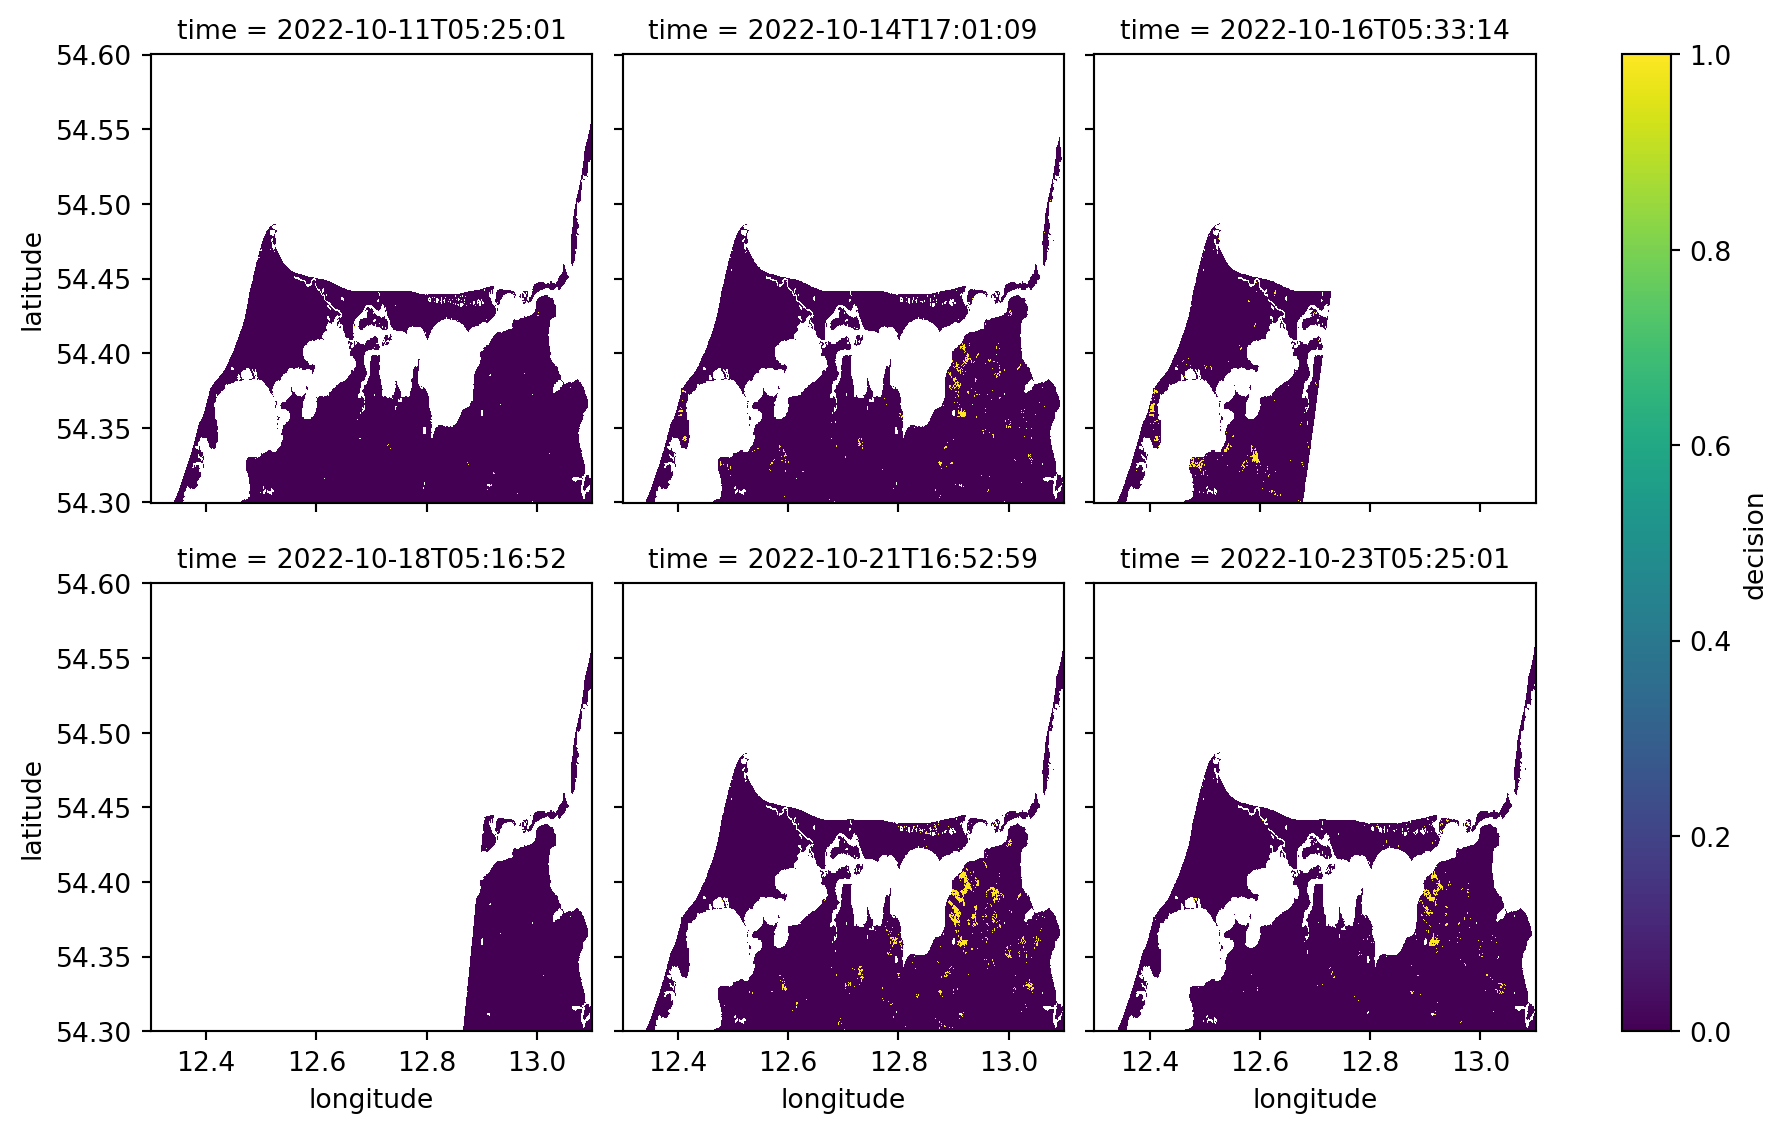

In [33]:
flood_output.plot(col="time", col_wrap=3)

In the following graphic we superimpose the data on a map and we can move the slider to see which areas become flooded over time.


In [34]:
flood_output.hvplot.quadmesh(x='longitude', y='latitude', geo=True, widget_location='bottom', rasterize=True, \
                            project=True, clim=(0,1), cmap=["rgba(0, 0, 1, 0.1)","darkred"], tiles=True, \
                            clabel="        non-flood                                        flood")

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom')
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='time', options={'2022-10-11 05:25:01': np...}, value=np.datetime64('2022-10-11T...)